In [1]:
import torch
import torch.optim
import torch.nn as nn

from pruning.unstructured import OneShotPruning
from models import LeNet
from utils import compute_accuracy, DATASETS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Set the arguments before we start

In [2]:
args_dict = {
    "prune_ratio": 0.4,
    "sparsity_reg": "none",
    "retrain_mode": "weight-rewinding",
    
    "model_path": "./saved_models/oneshot",
    "seed": 2020,
    "batch_size": 128,
    "init_lr": 0.001,
    "weight_decay": 1e-4,
    "train_epochs": 50,
    "retrain_epochs": 50,
    "rewind_epoch": 1.4, # 1.4 chosen as per the "The Lottery Ticket Hypothesis at Scale" paper
    "use_early_stop": True,
    "patience":10
}

class Args():
    def __init__(self):
        pass
args = Args()
for k,v in args_dict.items():
    setattr(args, k, v)

# Get the DataLoaders and the Model

In [3]:
dataset = DATASETS['MNIST']
train_loader, val_loader, test_loader = dataset['loaders'](args, seed=2020)

In [4]:
criterion = criterion = nn.CrossEntropyLoss().cuda()
model = LeNet(dataset['num_classes'], criterion, device)
model = model.to(device)

In [5]:
optimizer = torch.optim.SGD(model.parameters(), args.init_lr, momentum=0.9, weight_decay=1e-4)
lr_scheduler = None

# Define the parameters to prune

check the parameter list by running the following cell

In [6]:
[name for name, _ in model.named_parameters()]

['conv1.weight',
 'conv1.bias',
 'conv2.weight',
 'conv2.bias',
 'fc1.weight',
 'fc1.bias',
 'fc2.weight',
 'fc2.bias']

In [7]:
def parameters_to_prune(m):
    return [
        (m.conv1, 'weight'), (m.conv2, 'weight'),
        (m.fc1, 'weight'), (m.fc2, 'weight'),
    ]

# Lets get the Lottery Ticket

reference: [Lottery Ticket Hypothesis](https://arxiv.org/abs/1803.03635)

In [8]:
one_shot_pruning = OneShotPruning(model, parameters_to_prune, optimizer, lr_scheduler, train_loader, val_loader, compute_accuracy, device, args)

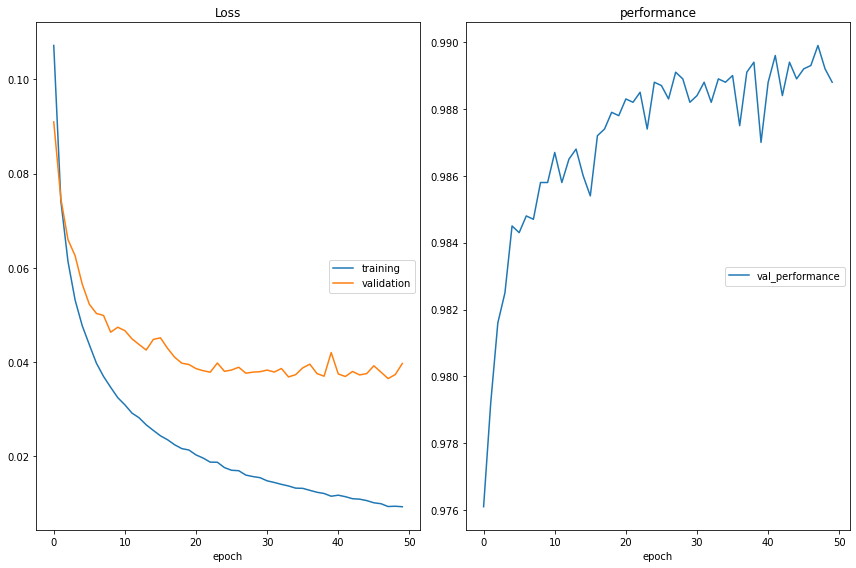

  0%|          | 0/79 [00:00<?, ?it/s]

Loss
	training         	 (min:    0.009, max:    0.107, cur:    0.009)
	validation       	 (min:    0.036, max:    0.091, cur:    0.040)
performance
	val_performance  	 (min:    0.976, max:    0.990, cur:    0.989)


100%|██████████| 79/79 [00:00<00:00, 90.89it/s]

 val accuracy (original): 0.9895
 val accuracy (pruned): 0.9826 
 val accuracy (retrained): 0.9888 


In [9]:
_, ckpt_orig_path, ckpt_pruned_path, loss_history_orig, loss_history_pruned = one_shot_pruning.get_ticket()